# Udacity Data Analyst Nanodegree

## P2: Investigate a Dataset

By: Adam Friedman

March 2017

----------------------

#### Data set:
[Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/)

#### Question:
Do left handed and ambidextrous batters have an advantage over right handed batters?

----------------------

To define an advantage, I'll be using 3 different batting metrics:

* Batting average = number of hits divided by number of at bats<br/>
* Slugging percentage = total bases divided by at bats<br/>
* Home runs = number of home runs hit divided by at bats

Terminology:

* <a href="https://en.wikipedia.org/wiki/Hit_(baseball)">Hit</a> -  a hit is credited to a batter when the batter reaches first base after hitting the ball into [fair](https://en.wikipedia.org/wiki/Fair_ball) territory, without the benefit of an <a href="https://en.wikipedia.org/wiki/Error_(baseball)">error</a> or a [fielder's choice](https://en.wikipedia.org/wiki/Fielder%27s_choice "fielder's choice")
* At Bat - a batter's turn against a pitcher with a few [exceptions](https://en.wikipedia.org/wiki/At_bat)
* [Home Run](https://en.wikipedia.org/wiki/Home_run) - a home run is scored when the batter circles all the bases and reach home safely in one play. This usually occurs when the ball is hit over the outfield fence


For this assignment I'm using the 2016 version of Lahman's Baseball Database, available [here](http://www.seanlahman.com/baseball-archive/statistics/).

Notation for the type of batter:
* R - right handed batter
* L - left handed batter
* B - bats with both hands (ambidextrous)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline

#import the relevant information from the csv files
master_df = pd.read_csv("Master.csv", usecols=['playerID','bats'])
batting_df = pd.read_csv("Batting.csv")

#Merge the 2 tables by playerID
project_df = batting_df.merge(master_df, on='playerID', how='left')

#Check for duplicate player IDs
project_df['YearPlayer'] = project_df['yearID'].astype(str) + project_df['playerID']+project_df['stint'].astype(str)
print('Number of duplicate player IDs:')
print(project_df['YearPlayer'].nunique()-project_df['YearPlayer'].count())

#Check for Nan values
print("")
print("Missing values per column:")
print("")
print(project_df.isnull().sum())


Number of duplicate player IDs:
0

Missing values per column:

playerID          0
yearID            0
stint             0
teamID            0
lgID            737
G                 0
AB                0
R                 0
H                 0
2B                0
3B                0
HR                0
RBI             424
SB             1300
CS            23456
BB                0
SO             7838
IBB           36565
HBP            2810
SH             6338
SF            36034
GIDP          26110
bats           1922
YearPlayer        0
dtype: int64


Taking the yearID, playerID and stint into account, there has been no duplication of player's batting stats.

For this analysis playerID, yearID, AB, H, 2B, 3B, HR and bats will be used. Out of all of these columns, only bats has NaN values. Let's have a closer look to understand the data in the bats column

In [3]:
def decade_assign(year):
    if year < 1900:
        return '1800s'
    elif year >= 2010:
        return '2010s'
    elif year >= 2000:
        return '2000s'
    else:
        return "19"+str(year)[2]+"0's"

project_df['Decade'] = project_df['yearID'].apply(decade_assign)
project_df['bats'].fillna('No Val',inplace='true')

pd.pivot_table(project_df,index=['bats'],columns='Decade',values='playerID',aggfunc='count',dropna=False,margins=True)


Decade,1800s,1900's,1910's,1920's,1930's,1940's,1950's,1960's,1970's,1980's,1990's,2000s,2010s,All
bats,,,,,,,,,,,,,,
B,347.0,321.0,454.0,314.0,215.0,236.0,233.0,412.0,740.0,1026.0,1229.0,1203.0,795.0,7525.0
L,1532.0,1152.0,1650.0,1620.0,1516.0,1672.0,1875.0,2156.0,2572.0,2873.0,3204.0,3793.0,2931.0,28546.0
No Val,1662.0,225.0,33.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1922.0
R,4361.0,2473.0,3928.0,3373.0,3507.0,3869.0,4040.0,4991.0,5882.0,6148.0,7407.0,8604.0,6240.0,64823.0
All,7902.0,4171.0,6065.0,5309.0,5238.0,5777.0,6148.0,7559.0,9194.0,10047.0,11840.0,13600.0,9966.0,102816.0


Once the values have been broken down per decade, we can see that the 'bats' column has many missing entries before 1900, but from 1930 every player has been assigned a value. We can also see that more players are recorded as ambidextrous (B) in recent years compared to 100 years ago even when taking the growth of the total number of players per decade into account.

This leads to the question of what time frame should be looked at for this analysis. Since the start of Major League Baseball there have been many eras of the game which have been brought on by many factors e.g. rule changes. In addition, from examining the table above, either more left handed and ambidextrous people have joined the MLB or there has been a change in the way the data is recorded.

There is no concensus as to when the modern era of baseball started, so I have read expert opinions and for the purpose of this report I have chosen 1969 as the start of the modern era. Some of the rule changes in that year include lowering the pitching mound and reducing the strikezone, therefore making the game more offense orientated. The following links contain more information about why 1969 can be argued as the start of the modern era:
http://www.espn.com/mlb/columns/story?id=2471349&columnist=stark_jayson <br/>
http://www.huffingtonpost.com/quora/what-are-the-major-eras-o_b_3547814.html


In [4]:
#Limit the data to batting appearances from 1969 onwards
project_df = project_df[project_df['yearID'] >= 1969]

#The data also needs to be limited to players with At Bats >= 1 to remove all players in the data who never batted
project_df = project_df[project_df['AB'] >= 1]

Studies suggest that about 10% of the world is left handed and about 1% is ambidextrous (source: https://en.wikipedia.org/wiki/Handedness). It looks like far more MLB players are using their left hand. Let's investigate further, isolating the percentages for 2016 only:

In [5]:
bats_sum = project_df[project_df['yearID']==2016].groupby(by='bats').playerID.nunique()
bats_perc = (bats_sum/bats_sum.sum()*100).round(1)
pd.DataFrame(bats_perc.astype(str)+'%')


,playerID
bats,
B,9.6%
L,28.6%
R,61.8%


Although there are instances where players are represented multiple times in this table, the percentages are far from those of the general population. The next step is to get an idea of each player's batting stats over the span of their careers. This requires some data aggregation:

In [6]:
#Each row currently represents a player's stats per stint per year. The data needs to be aggregated in order show
#each player's stats for their whole MLB career
batter_stats = project_df[['H','2B','3B','HR','AB','playerID','bats']].groupby(by=['playerID','bats'],as_index=False).sum()

#Set up the batting measurements
batter_stats['HR/AB'] = batter_stats['HR']/batter_stats['AB']
batter_stats['Bavg'] = batter_stats['H']/batter_stats['AB']
batter_stats['1B'] = batter_stats['H'] - batter_stats['2B'] - batter_stats['3B'] - batter_stats['HR']
batter_stats['SPerc'] = (batter_stats['1B'] + (batter_stats['2B']*2) + (batter_stats['3B']*3) + (batter_stats['HR']*4)) / batter_stats['AB']

batter_stats.sort_values(by = 'SPerc', ascending = False).head()

,playerID,bats,H,2B,3B,HR,AB,HR/AB,Bavg,1B,SPerc
4832,munnisc01,R,1,0,1,0,1,0.0,1.0,0,3.0
5926,rodried01,R,1,0,1,0,1,0.0,1.0,0,3.0
1050,cammaer01,R,1,0,1,0,1,0.0,1.0,0,3.0
7607,yanes01,R,2,0,0,1,2,0.5,1.0,1,2.5
4130,lyonbr01,R,1,1,0,0,1,0.0,1.0,0,2.0


Sorting the data to show the top performers by Slugging %, it's clear that theres an issue relating to batters with few performances. Looking at the top 5 in the table above, we're not looking at the best batters in modern baseball. Instead, we have extreme outliers who only faced one or two pitches. Although we have to assume that the numbers recorded for these outliers are legitimate, it calls into question the minimum number of pitches a batter should face in order to gauge their skill. I propose to remove the batters who have recorded At Bats which fall into the lower quartile.

In [7]:
batter_stats['AB'].describe()

count     7677.000000
mean       933.407711
std       1752.341612
min          1.000000
25%         14.000000
50%        116.000000
75%        886.000000
max      11551.000000
Name: AB, dtype: float64

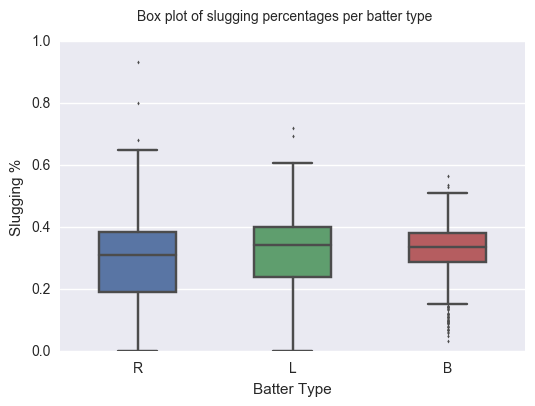

In [36]:
#Remove the batters in the lowest quartile for AB
batter_stats = batter_stats[batter_stats['AB'] > 14]

#Graph a boxplot based on Slugging %
g = sns.boxplot(data=batter_stats, y='SPerc',x='bats',fliersize=2, width = 0.5)
g.set(xlabel='Batter Type', ylabel="Slugging %")
plt.suptitle('Box plot of slugging percentages per batter type')

Although there are still outliers, the range of the Slugging % values has decreased by 66%. Sometimes zero values can be a concern, but in this case there were players who faced multiple pitches but never scored any 'hits', so these values must be kept.

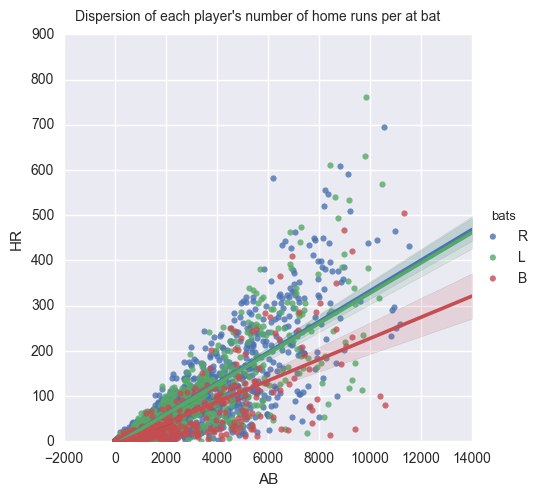

In [37]:
s = sns.lmplot(data=batter_stats,x='AB', y='HR',hue='bats')
s.set(ylim=(0,900))
plt.suptitle("Dispersion of each player's number of home runs per at bat")
plt.subplots_adjust(top=0.93)

The scatter plot illustrates the wide range of the number of home runs scored by different batters. At around 8000 At Bats, there are instances where batters have hit about 550 home runs in their career, but there are also batters who have only hit about 50 homeruns. I'm making the assumption that to reach 8000 At Bats the batter has to be a good player, otherwise the coach wouldn't have afforded him so many opportunities. We can therefore deduce that being a good player who's very experienced, doesn't guarantee homeruns!

In [10]:
means_summary = batter_stats[['HR/AB','Bavg','SPerc','bats']].groupby(by='bats',).mean().transpose().round(3)
means_summary = means_summary.rename(index={'Bavg': 'Batting Average','SPerc':'Slugging %'})
means_summary

bats,B,L,R
HR/AB,0.014,0.017,0.016
Batting Average,0.229,0.218,0.201
Slugging %,0.323,0.318,0.291


It seems like the means do differ between the groups of batters. To find out whether the differences are statistically significant, I will conduct two tailed t-tests with significance levels of 1%. This equates to t-critical values of (2.576, -2.576).

For each test, the null hypothesis (H0) will be: the population mean of group1 (μ1) is equal to the population mean of group2 (μ2). The alternate hypothesis (H1) will be: the population mean of group1 (μ1) is significantly different to the population mean of group2 (μ2).

In [11]:
res_str = 'The t-statistic is %6.4f and the pvalue is %6.4f'

#Batting average t tests
bavg_r = batter_stats[batter_stats['bats']=='R']['Bavg']
bavg_l = batter_stats[batter_stats['bats']=='L']['Bavg']
bavg_b = batter_stats[batter_stats['bats']=='B']['Bavg']

print('Batting Average R vs L')
tt,pval = ttest_ind(bavg_r,bavg_l,equal_var=False)
print(res_str %(tt,pval))

print('Batting Average R vs B')
tt,pval = ttest_ind(bavg_r,bavg_b,equal_var=False)
print(res_str %(tt,pval))

print('Batting Average L vs B')
tt,pval = ttest_ind(bavg_l,bavg_b,equal_var=False)
print(res_str %(tt,pval))

print("")


#Slugging Percentage t tests
sperc_r = batter_stats[batter_stats['bats']=='R']['SPerc']
sperc_l = batter_stats[batter_stats['bats']=='L']['SPerc']
sperc_b = batter_stats[batter_stats['bats']=='B']['SPerc']

print('Slugging Percentage R vs L')
tt,pval = ttest_ind(sperc_r,sperc_l,equal_var=False)
print(res_str %(tt,pval))
print('Slugging Percentage R vs B')
tt,pval = ttest_ind(sperc_r,sperc_b,equal_var=False)
print(res_str %(tt,pval))
print('Slugging Percentage L vs B')
tt,pval = ttest_ind(sperc_l,sperc_b,equal_var=False)
print(res_str %(tt,pval))


print("")

#HR/AB t tests
hr_r = batter_stats[batter_stats['bats']=='R']['HR/AB']
hr_l = batter_stats[batter_stats['bats']=='L']['HR/AB']
hr_b = batter_stats[batter_stats['bats']=='B']['HR/AB']

print('HR/AB R vs L')
tt,pval = ttest_ind(hr_r,hr_l,equal_var=False)
print(res_str %(tt,pval))
print('HR/AB R vs B')
tt,pval = ttest_ind(hr_r,hr_b,equal_var=False)
print(res_str %(tt,pval))
print('HR/AB L vs B')
tt,pval = ttest_ind(hr_l,hr_b,equal_var=False)
print(res_str %(tt,pval))

Batting Average R vs L
The t-statistic is -8.5025 and the pvalue is 0.0000
Batting Average R vs B
The t-statistic is -11.5613 and the pvalue is 0.0000
Batting Average L vs B
The t-statistic is -4.2723 and the pvalue is 0.0000

Slugging Percentage R vs L
The t-statistic is -7.5756 and the pvalue is 0.0000
Slugging Percentage R vs B
The t-statistic is -7.4616 and the pvalue is 0.0000
Slugging Percentage L vs B
The t-statistic is -1.0133 and the pvalue is 0.3111

HR/AB R vs L
The t-statistic is -3.0189 and the pvalue is 0.0026
HR/AB R vs B
The t-statistic is 3.2077 and the pvalue is 0.0014
HR/AB L vs B
The t-statistic is 5.1245 and the pvalue is 0.0000


## Conclusion

In all 3 of the R vs L tests the null hypotheses can be rejected. Left handed batters do seem to have an advantage over right handed batters in baseball.

The null hypotheses can also be rejected to show that ambidextrous hitters have better batting averages than left handed hitters but also fewer homeruns per at bat than left handed hitters.

There are too many factors at play to pinpoint every reason why left handed batters have an advantage. Some common theories are:
* Left handed batters stand a few steps closer to first base and the momentum from the shot helps them run in that direction
* A left handed batter facing a right handed pitcher has a clearer view of the ball as it travels towards him compared to the view of a right handed batter<br/>
[source](http://www.livescience.com/2665-baseball-rigged-lefties.html)

The clearer view of the ball theory can also explain why ambidextrous hitters have the best batting average. Once the pitcher has declared which hand he will pitch from, the batter can then choose the opposite stance, thus giving himself the clearest view of the ball.

Given the large difference between the percentage of MLB left handed batters and the percentage of left handed people in the general population, it also makes sense intuitively that lefties must have an advantage in order to create this difference in an *extremely* competitive environment.

One must keep in mind that this analysis is limited to the years 1969 - 2016. The results could change depending on the definition of the modern era and thus the period of time analysed. Various rules implemented throughout the history of the game could have unequal consequences for the different batter types. There is also a data limitation with the ambidextrous batters because the data only shows how many at bats to count but not the split of at bats (and scoring data) between each batting stance.

In order to delve deeper into the advantages and differences, more test statistics could be introduced in order to provide additional measures of performance for batting, pitching and fielding. Multiple statistics could be combined in a model to produce one overall measurement of a player's performance and this could give a better idea of a player's total value to their team. 

In [12]:
top20 = batter_stats[batter_stats['AB']>100][['playerID','Bavg','bats']].sort_values(by='Bavg',ascending=False).head(20)
top20[top20['bats']=='L']['bats'].count()

9

It should come as no surprise then that 9 out of the top 20 players ranked by batting average are lefties!